In [13]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

%matplotlib inline

# Parse Data

In [14]:
# directories with input, file prefixes
INPUT_DIR = './predictions/'
ORIGINAL_MODEL_FILE_PREFIX = 'batch5-2017-06-05T07:58:47'
NEW_MODEL_FILE_PREFIX = 'output-2020-07-22T14:10:40'
NEW_MODEL_OUTPUT_DIR = './results/new/'
ORIGINAL_MODEL_OUTPUT_DIR = './results/original/'

In [15]:
# open up the dataset for the original model
original_model = pd.read_csv('{0}{1}-predictions.csv'.format(INPUT_DIR, ORIGINAL_MODEL_FILE_PREFIX))
original_model.head()

pdbid  predicted  real       set
0  11gs   6.807291  5.82  training
1  13gs   5.665529  4.62  training
2  16pk   4.755159  5.22  training
3  184l   5.689533  4.72  training
4  185l   4.648183  3.54  training

In [16]:
# open up the dataset for the new model
new_model = pd.read_csv('{0}{1}-predictions.csv'.format(INPUT_DIR, NEW_MODEL_FILE_PREFIX))
new_model.head()

pdbid  real  predicted       set
0  10gs_ligand  6.40   6.076756  training
1  11gs_ligand  5.82   6.468234  training
2  13gs_ligand  4.62   5.721385  training
3  16pk_ligand  5.22   5.475455  training
4  184l_ligand  4.72   4.363130  training

In [17]:
# extract each set
# for the original model
original_model_training = original_model.loc[original_model['set'] == 'training']
original_model_validation = original_model.loc[original_model['set'] == 'validation'].reset_index(drop=True)
original_model_test = original_model.loc[original_model['set'] == 'test'].reset_index(drop=True)

original_datasets = (original_model_training, original_model_validation, original_model_test)

In [18]:
# for the new model
new_model_training = new_model.loc[new_model['set'] == 'training']
new_model_validation = new_model.loc[new_model['set'] == 'validation'].reset_index(drop=True)
new_model_test = new_model.loc[new_model['set'] == 'test'].reset_index(drop=True)

new_datasets = (new_model_training, new_model_validation, new_model_test)
names = ('training', 'validation', 'test')

# Calculate Performance Metrics for Each Model

So we calculate two performance metrics - the Pearson Correlation Coefficient (R) and the Root Mean Squared Error (RMSE).

The Pearson Correlation Coefficient measures the linear correlation between two variables X and Y, which in this case is the real and predicted binding affinities of each complex. It has a value from -1 to +1, where +1 is complete linear correltation, 0 is no linear correlation, and -1 is compelete negative linear correlation. So, the closer R is to 1, the more accurate our model is at predicting binding affinities.

![Formula for Pearson Correlation Coefficient](pearson_correlation_coefficient_formula.png)

The Root Mean Squared Error (RMSE) is the standard deviation of the distribution of the error (or residuals) between two variables X and Y (which again, in this case are the real and predicted binding affinities). While residuals measure how far each data point is from the regression line (or the line of best fit), RMSE tells us *how spread out* these residuals are, or how concentrated the data is around the regression line.

![Formula for RMSE](rmse_formula.png)

In [19]:
# calculate rmse, and r for every dataset
def calculate_rmse(real, predicted):
    return round(np.sqrt(mean_squared_error(real, predicted)), 2)

def calculate_r(real, predicted):
    _r, _ = pearsonr(real, predicted)
    return round(_r, 2)

def calculate_performance_metrics(datasets, names):
    rmse = {}
    r = {}
    
    for dataset, name in zip(datasets, names):
        real = dataset['real'].reset_index(drop=True)
        predicted = dataset['predicted'].reset_index(drop=True)

        rmse[name] = calculate_rmse(real, predicted)
        r[name] = calculate_r(real, predicted)
        
    return rmse, r

In [20]:
rmse_original, r_original = calculate_performance_metrics(original_datasets, names)
original_model_metrics = (rmse_original, r_original)

rmse_new, r_new = calculate_performance_metrics(new_datasets, names)
new_model_metrics = (rmse_new, r_new)

# Predictions on Training, Validation and Test Sets for Original Model

In [21]:
def draw_predictions(datasets, metrics, names, colors, output_dir):
    rmse, r = metrics
    for dataset, name, color in zip(datasets, names, colors):
        # training set
        grid = sns.jointplot(x="real", y="predicted", data=dataset, edgecolor='black', color=color)
        grid.fig.suptitle('{0} set'.format(name), fontsize=26, y=1.04, horizontalalignment='center')
        grid.ax_joint.set_xlabel('real', fontsize=20)
        grid.ax_joint.set_ylabel('predicted', fontsize=20)
        grid.ax_marg_x.set_xlim(0, 15)
        grid.ax_marg_y.set_ylim(0, 15)
        # add MAE, RMSE and R
        grid.ax_joint.text(0.9, 13, 'RMSE: {0}\n       R: {1}'.format(rmse[name], r[name]), fontsize=18)
        # save it
        grid.savefig('{0}{1}.png'.format(output_dir, name))

/home/king-shak/anaconda3/envs/pafnucy_env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


RMSE     R
Dataset               
Training    1.21  0.77
Validation  1.44  0.72
Test        1.42  0.77

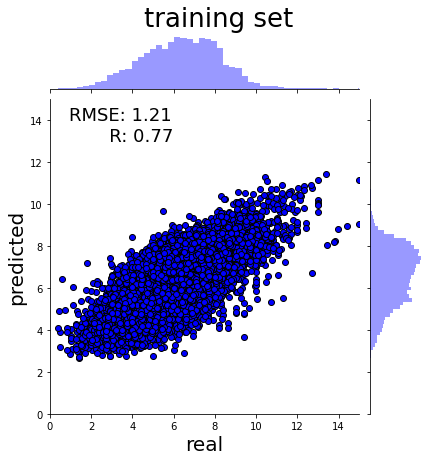

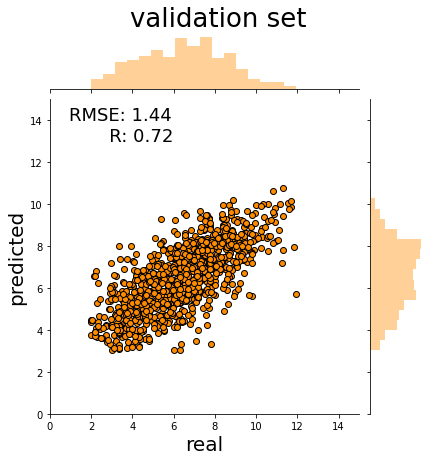

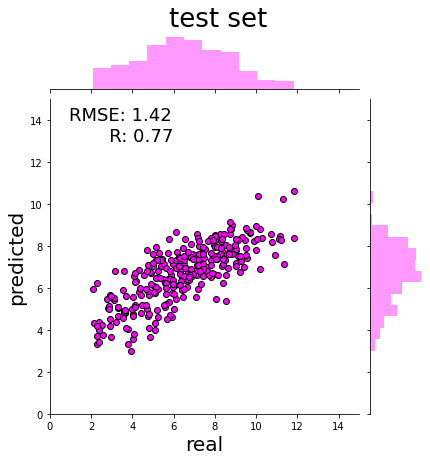

In [22]:
# now we graph it - for the old model
colors = ('blue', 'darkorange', 'magenta')
draw_predictions(original_datasets, original_model_metrics, names, colors, ORIGINAL_MODEL_OUTPUT_DIR)
data = {
    'Dataset': ['Training', 'Validation', 'Test'],
    'RMSE': list(rmse_original.values()),
    'R': list(r_original.values())
}

original_model_performance = pd.DataFrame(data=data)
original_model_performance.set_index('Dataset', inplace=True)
original_model_performance

# Predictions on Training, Validation and Test Sets for New Model

/home/king-shak/anaconda3/envs/pafnucy_env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


RMSE     R
Dataset               
Training    1.35  0.69
Validation  1.44  0.69
Test        1.46  0.76

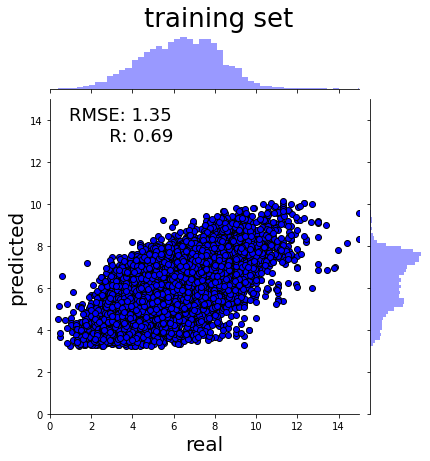

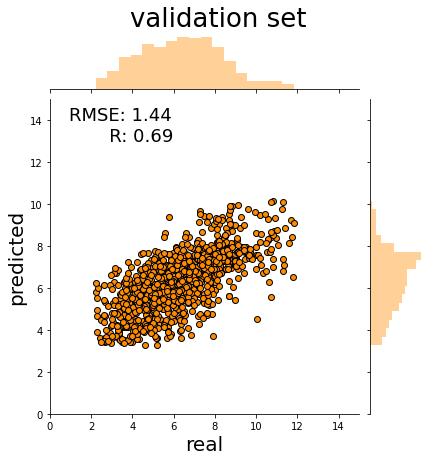

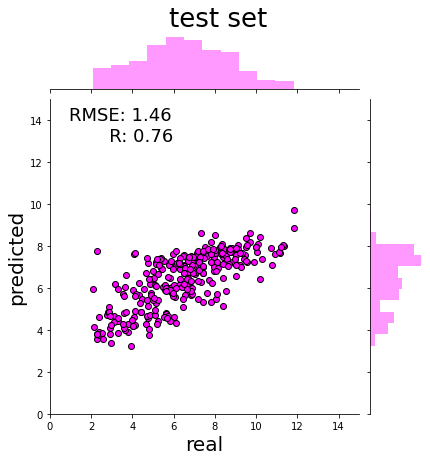

In [23]:
draw_predictions(new_datasets, new_model_metrics, names, colors, NEW_MODEL_OUTPUT_DIR)

data = {
    'Dataset': ['Training', 'Validation', 'Test'],
    'RMSE': list(rmse_new.values()),
    'R': list(r_new.values())
}
new_model_performance = pd.DataFrame(data=data)
new_model_performance.set_index('Dataset', inplace=True)
new_model_performance

# Original vs New Model on Core 2016 (test) Set

In [24]:
# now compare the performace of the two on the core 2016 (test) set
data = {
    'Model': ['New', 'Old'],
    'RMSE': [rmse_original['test'], rmse_new['test']],
    'R': [r_original['test'], r_new['test']]
}
performance_on_2016_core = pd.DataFrame(data=data)
performance_on_2016_core.set_index('Model', inplace=True)
performance_on_2016_core

RMSE     R
Model            
New    1.42  0.77
Old    1.46  0.76